In [9]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The scalene extension is already loaded. To reload it, use:
  %reload_ext scalene


In [10]:
# axis_font = {'fontname':'Arial', 'size':'14'}
axis_font = {'fontname':'Times New Roman', 'size':'16'}
sns.set_context(rc={'lines.linewidth':2})

In [64]:
X, y, features, categ, sch_nan = ds.load_support2_dataset()

df = X.copy()
df["time"] = y["time"]
df["cens"] = y["cens"]
df = df.fillna(0).replace(np.nan, 0).replace(np.inf, 0)

In [65]:
from lifelines.statistics import proportional_hazard_test

cph = CoxPHFitter(penalizer=0.00001).fit(df, 'time', 'cens')  # strata=[feat]

plt.figure(figsize=(14, 7))
cph.check_assumptions(df, p_value_threshold=0.1)

# results = proportional_hazard_test(cph, df, time_transform='rank')
# results.print_summary(decimals=3, model="untransformed variables")

The ``p_value_threshold`` is set at 0.1. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 9105 total observations, 2904 right-censored observations>
         test_name = proportional_hazard_test

---
                   test_statistic      p  -log2(p)
fac_ca       km              7.87   0.01      7.64
             rank            8.07 <0.005      7.79
fac_dementia km              5.88   0.02      6.03
             rank            5.89   0.02      6.04
fac_diabetes km              6.98   0.01      6.92
             rank            7.20   0.01      7.10
fac_dnr      km              2.92   0.09      3.52
             rank            3.34   0.07      3.89
fac_dzclass  km             13.31 <0.005     11.88
             rank           13.58 <0.005     12.09
fac_dzgroup  km              0.05   0.82      0.29
             rank            0.05   0.82      0.29
fac_income   km              1.19   0.27      1.87
             rank            1.05   0.31      1.71
fac_num_co   km              0.00   0.98      0.02
             rank            0.00   0.98      0.02
fac_race     km              0.64   0.42      1.24
             rank            0.56   0.45      1.14
fac_sex      km             24.06 <0.005     20.03
             rank           23.68 <0.005     19.74
fac_sfdm2    km            835.71 <0.005    608.02
             rank          828.19 <0.005    602.59
num_adlp     km              2.95   0.09      3.54
             rank            3.03   0.08      3.62
num_adls     km              8.54 <0.005      8.17
             rank            9.70 <0.005      9.08
num_age      km              2.00   0.16      2.67
             rank            2.95   0.09      3.54
num_alb      km              0.46   0.50      1.01
             rank            0.55   0.46      1.13
num_bili     km              2.60   0.11      3.23
             rank            2.91   0.09      3.51
num_bun      km              0.36   0.55      0.87
             rank            0.38   0.54      0.90
num_crea     km              3.80   0.05      4.29
             rank            4.00   0.05      4.46
num_edu      km             15.29 <0.005     13.41
             rank           16.23 <0.005     14.12
num_glucose  km              0.10   0.75      0.41
             rank            0.13   0.72      0.48
num_hday     km              0.77   0.38      1.40
             rank            0.88   0.35      1.52
num_hrt      km              0.63   0.43      1.23
             rank            0.84   0.36      1.47
num_meanbp   km              2.58   0.11      3.21
             rank            2.74   0.10      3.36
num_num_co   km              0.00   0.98      0.02
             rank            0.00   0.98      0.02
num_pafi     km              4.61   0.03      4.97
             rank            4.72   0.03      5.07
num_ph       km             10.86 <0.005      9.99
             rank           10.67 <0.005      9.84
num_resp     km              0.37   0.54      0.89
             rank            0.50   0.48      1.06
num_scoma    km            170.05 <0.005    126.70
             rank          173.48 <0.005    129.19
num_sod      km              2.35   0.13      2.99
             rank            2.63   0.10      3.26
num_sps      km            233.18 <0.005    172.47
             rank          240.29 <0.005    177.62
num_surv2m   km              0.02   0.88      0.19
             rank            0.01   0.91      0.14
num_surv6m   km             44.65 <0.005     35.31
             rank           50.53 <0.005     39.63
num_temp     km              4.23   0.04      4.65
             rank            4.23   0.04      4.66
num_urine    km              8.54 <0.005      8.17
             rank            9.13 <0.005      8.63
num_wblc     km              1.13   0.29      1.80
             rank            1.16   0.28      1.83



1. Variable 'num_age' failed the non-proportional test: p-value is 0.0859.

   Advice 1: the functional form of the variable 'num_age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'num_age' using pd.cut, and then specify it in
`strata=['num_age', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'num_edu' failed the non-proportional test: p-value is 0.0001.

   Advice 1: the functional form of the variable 'num_edu' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

[]

<Figure size 1008x504 with 0 Axes>

In [66]:
from typing import List, Optional, Dict, Any, Iterable
from textwrap import dedent, fill
from autograd import numpy as anp
import numpy as np
from pandas import DataFrame, Series
from lifelines.statistics import proportional_hazard_test, TimeTransformers
from lifelines.utils import format_p_value
from lifelines.utils.lowess import lowess


def plot_assumptions(cph,
        training_df: DataFrame,
        p_value_threshold: float = 0.01,
        plot_n_bootstraps: int = 15,
        columns: Optional[List[str]] = None):    
    residuals = cph.compute_residuals(training_df, kind="scaled_schoenfeld")
    test_results = proportional_hazard_test(cph, training_df, time_transform=["rank", "km"], precomputed_residuals=residuals)

    residuals_and_duration = residuals.join(training_df[cph.duration_col])
    Xs = cph.regressors.transform_df(training_df)

    counter = 0
    n = residuals_and_duration.shape[0]
    axes = []

    for variable in cph.params_.index.intersection(columns or cph.params_.index):
        minumum_observed_p_value = test_results.summary.loc[variable, "p"].min()
        if np.round(minumum_observed_p_value, 2) > p_value_threshold:
            continue
        counter += 1
        # show plots
        axes.append([])
        fig = plt.figure(figsize=(14, 7))

        # plot variable against all time transformations.
        for i, (transform_name, transformer) in enumerate(TimeTransformers().iter(["rank", "km"]), start=1):
            p_value = test_results.summary.loc[(variable, transform_name), "p"]

            ax = fig.add_subplot(1, 2, i)

            y = residuals_and_duration[variable]
            tt = transformer(cph.durations, cph.event_observed, cph.weights)[cph.event_observed.values]

            ax.scatter(tt, y, alpha=0.75)

            y_lowess = lowess(tt.values, y.values)
            ax.plot(tt, y_lowess, color="k", alpha=1.0, linewidth=2)

            # bootstrap some possible other lowess lines. This is an approximation of the 100% confidence intervals
            for _ in range(plot_n_bootstraps):
                ix = sorted(np.random.choice(n, n))
                tt_ = tt.values[ix]
                y_lowess = lowess(tt_, y.values[ix])
                ax.plot(tt_, y_lowess, color="k", alpha=0.30)

            best_xlim = ax.get_xlim()
            ax.hlines(0, 0, tt.max(), linestyles="dashed", linewidths=1)
            ax.set_xlim(best_xlim)

            ax.set_xlabel("%s-transformed time\n(p=%.4f)" % (transform_name, p_value), fontsize=13)
            axes[-1].append(ax)

        fig.suptitle("Scaled Schoenfeld residuals of '%s'" % variable, fontsize=14)
        plt.tight_layout()
#         plt.subplots_adjust(top=0.90)

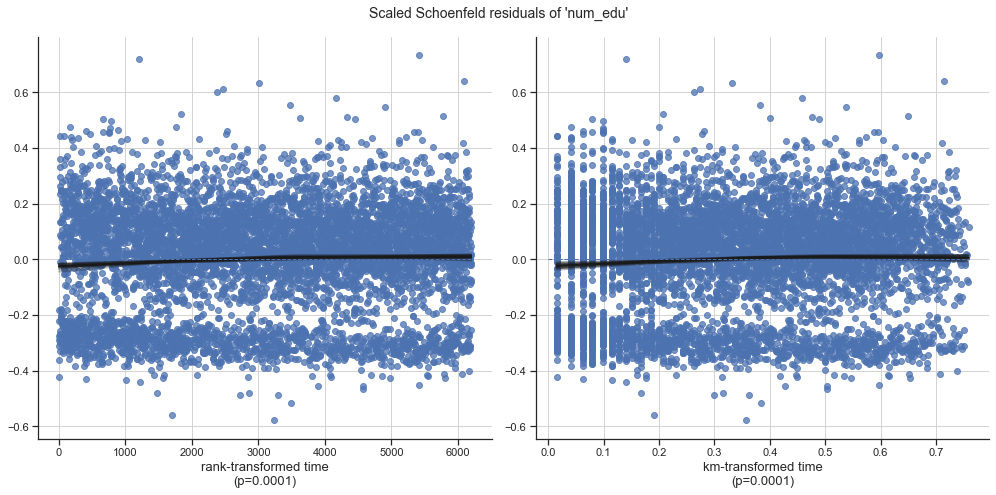

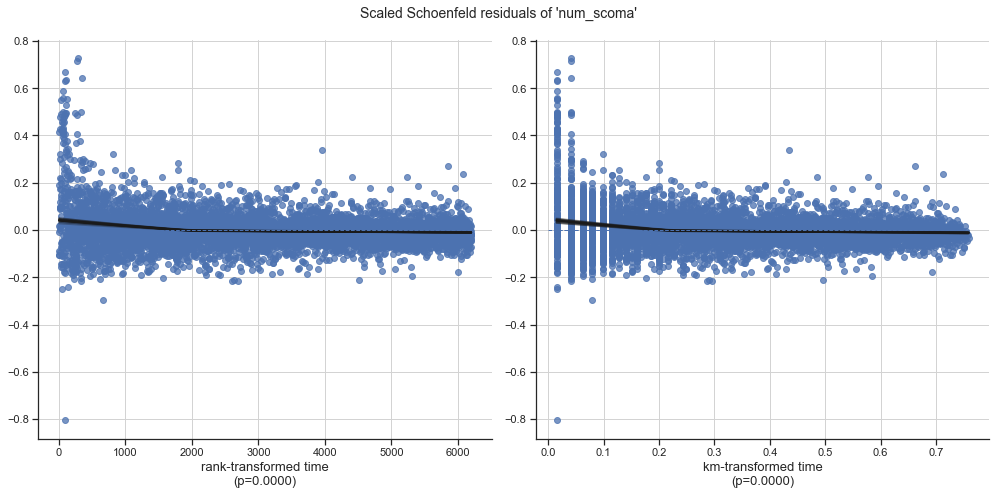

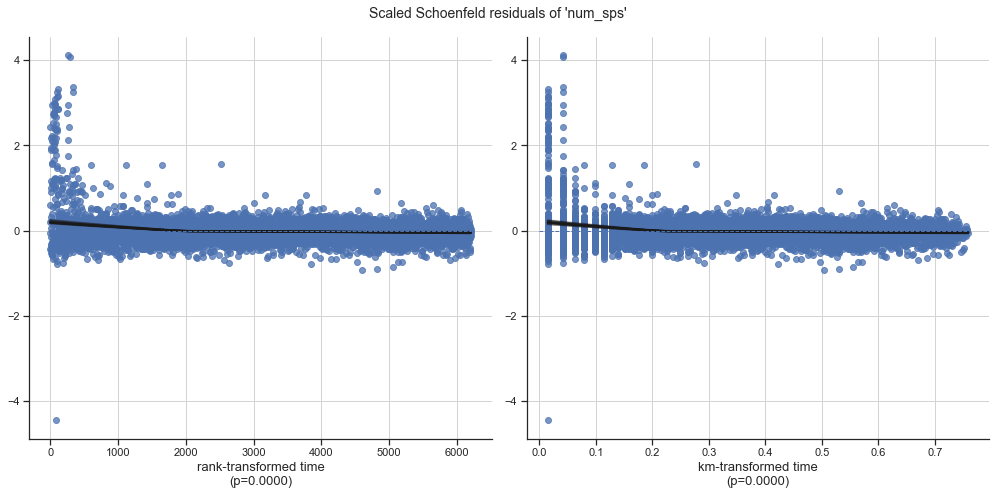

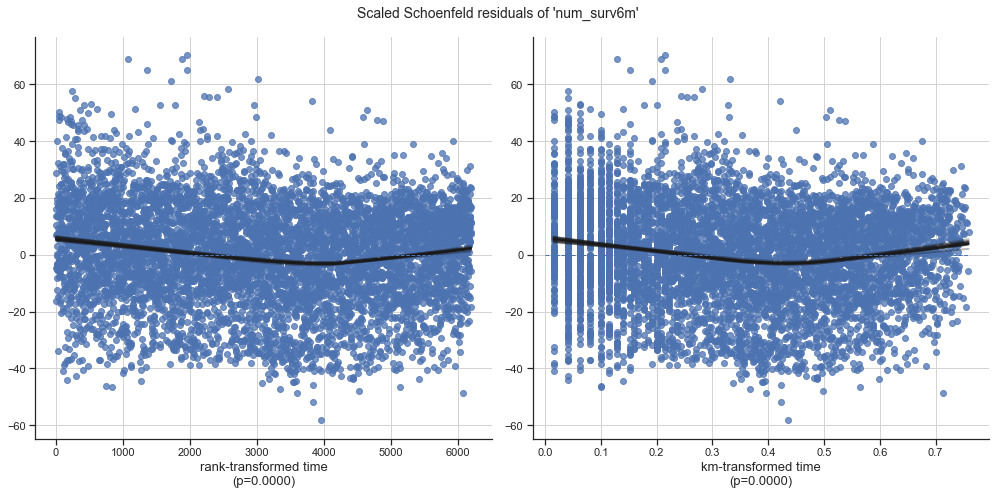

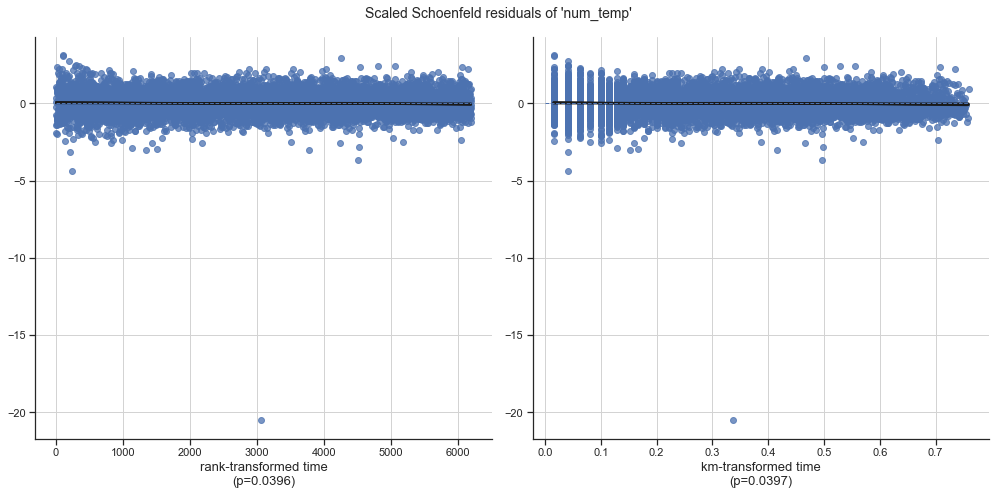

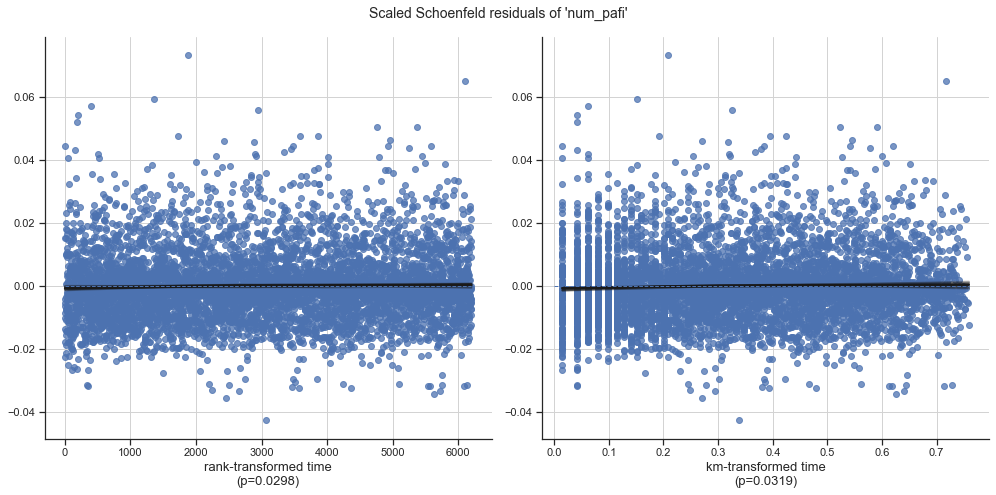

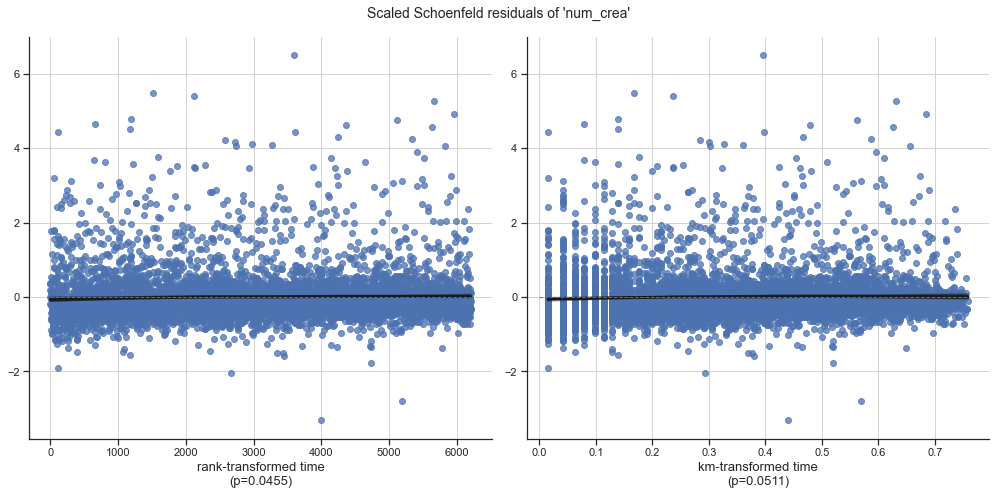

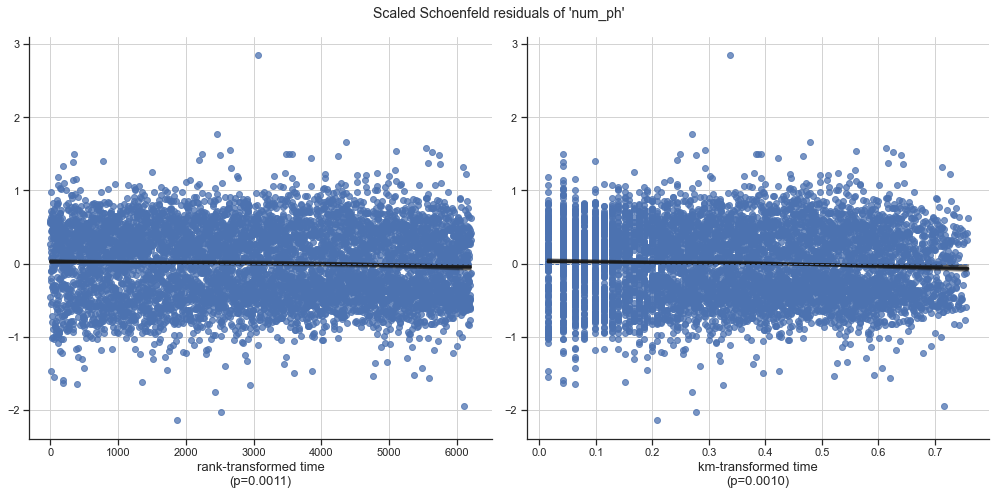

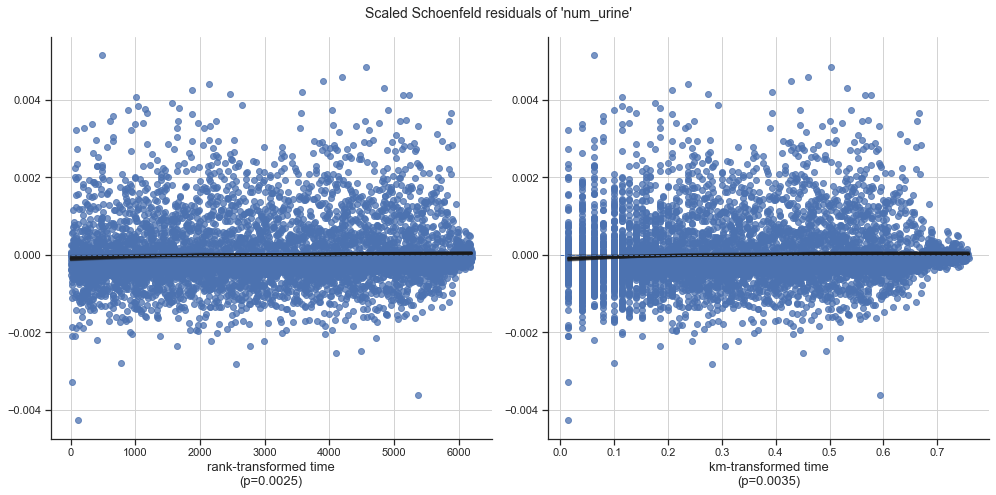

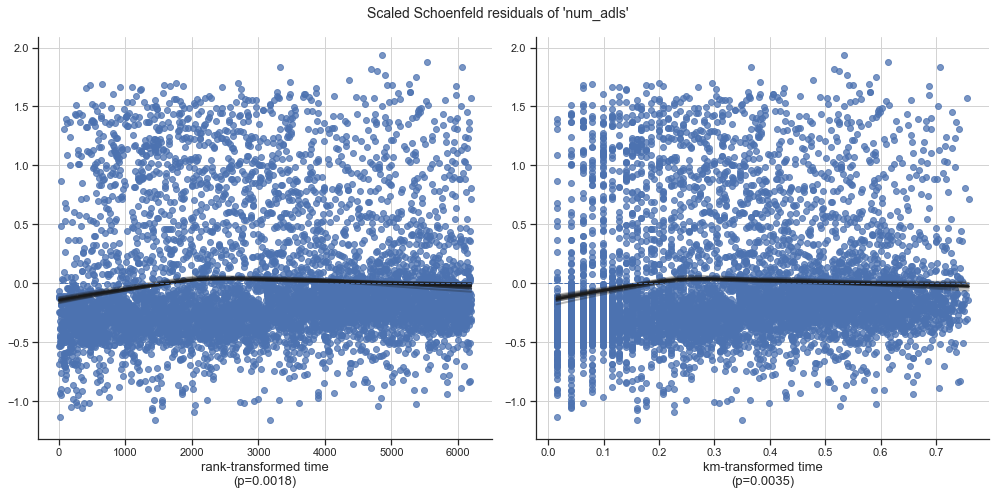

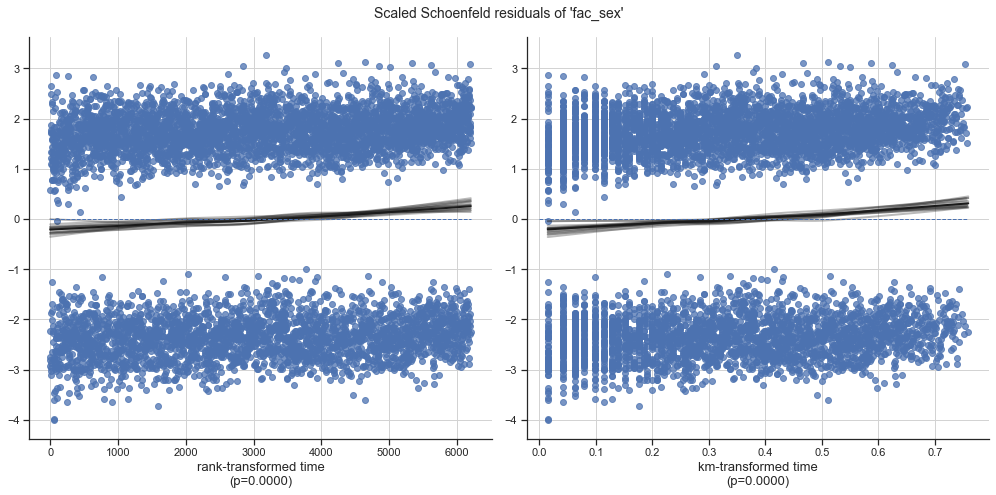

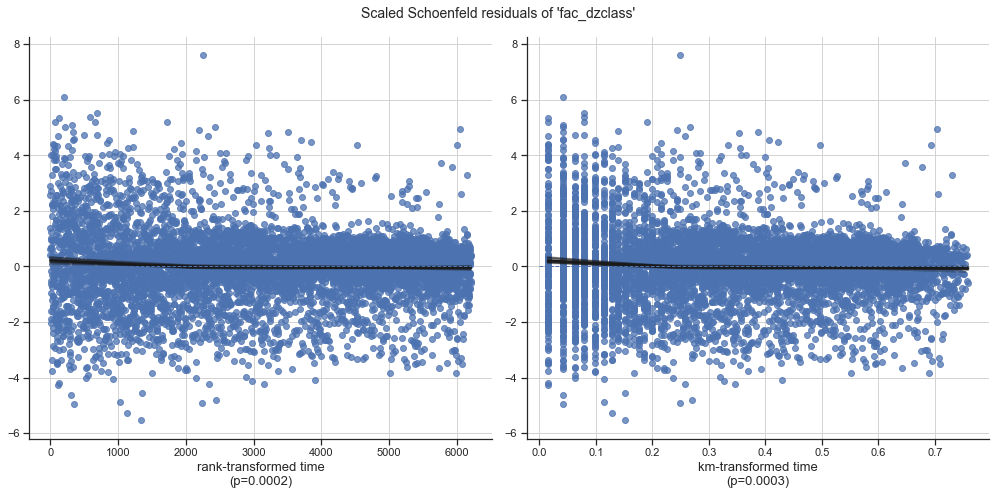

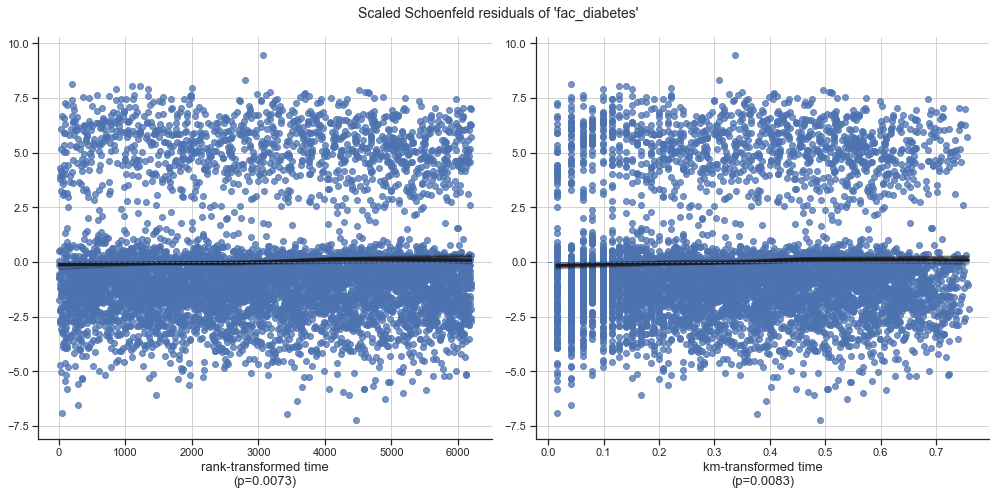

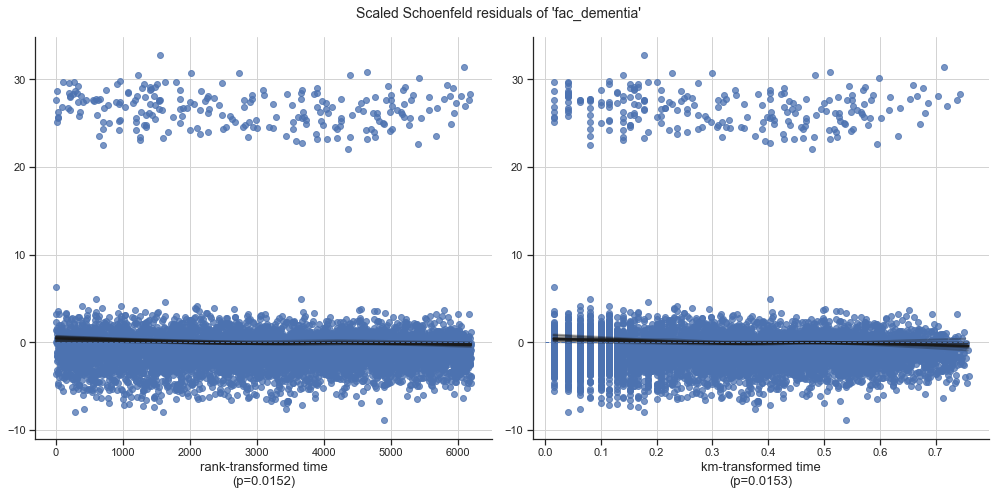

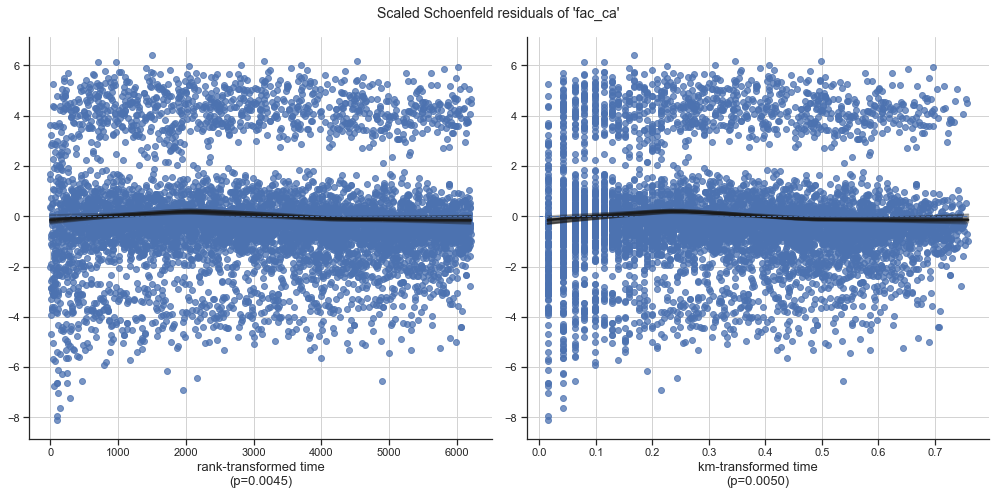

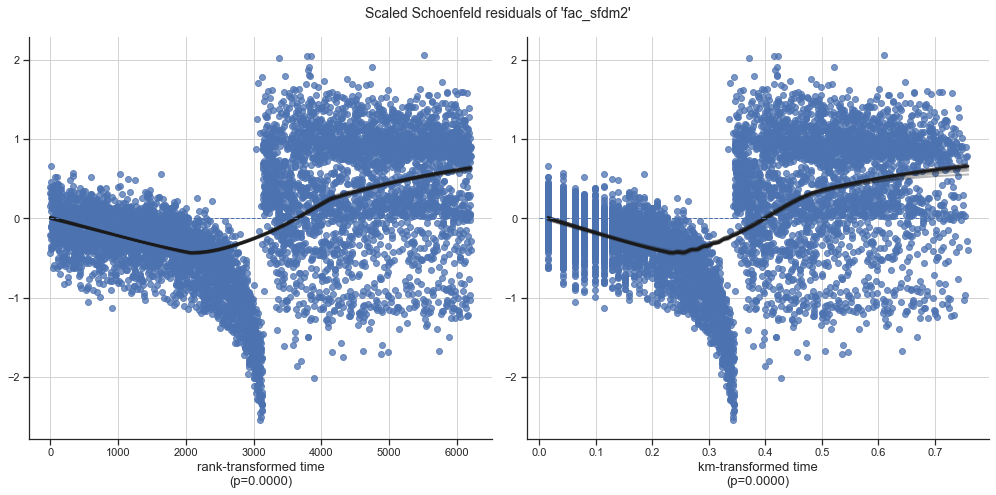

In [67]:
plot_assumptions(cph, df, p_value_threshold=0.05)

KeyError: 'tumgrad'

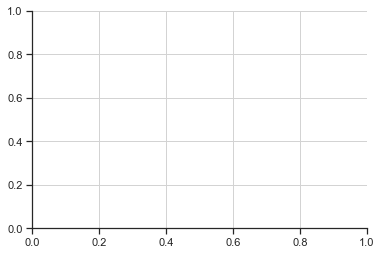

In [47]:
# feat = "menostat"  # GBSG (menostat)
feat = "tumgrad"  # PBC (sex, tumgrad)

bins = np.unique(y["time"])

fig, axs = plt.subplots(figsize=(6, 4))
for v in np.unique(df[feat]):
    index = df.query(f"{feat} == {v}").index
    
    kmf = KaplanMeierFitter()
    kmf.fit(df.loc[index]['time'], event_observed=df.loc[index]['cens'])
    sf_train = kmf.survival_function_at_times(bins).to_numpy()
    plt.plot(bins, sf_train, label=f"{feat}={v}")
plt.ylabel("Вероятность выживания", **axis_font)
plt.xlabel("Время", **axis_font)
plt.legend()

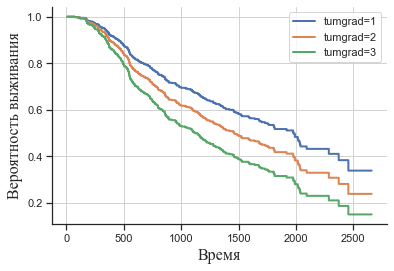

In [25]:
from lifelines import CoxPHFitter
df1 = df[[feat, "time", "cens"]]

cph.plot_partial_effects_on_outcome(feat, plot_baseline=False, 
                                    values=np.unique(X[feat]))
plt.ylabel("Вероятность выживания", **axis_font)
plt.xlabel("Время", **axis_font)
plt.legend()